<a href="https://colab.research.google.com/github/alonsosilvaallende/Exceso-de-mortalidad/blob/master/Comuna_Excess_Mortality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data_raw = pd.read_csv(
    "https://raw.githubusercontent.com/jorgeperezrojas/covid19-data/master/csv/muertes_deis/muertes_deis_rm.csv", index_col="comuna")

In [ ]:
comuna_RM = 'Lo Barnechea' #@param ['Alhué', 'Buin', 'Calera de Tango', 'Cerrillos', 'Cerro Navia', 'Colina', 'Conchalí', 'Curacaví', 'El Bosque', 'El Monte', 'Estación Central', 'Huechuraba', 'Independencia', 'Isla de Maipo', 'La Cisterna', 'La Florida', 'La Granja', 'La Pintana', 'La Reina', 'Lampa', 'Las Condes', 'Lo Barnechea', 'Lo Espejo', 'Lo Prado', 'Macul', 'Maipú', 'María Pinto', 'Melipilla', 'Ñuñoa', 'Padre Hurtado', 'Paine', 'Pedro Aguirre Cerda', 'Peñaflor', 'Peñalolén', 'Pirque', 'Providencia', 'Pudahuel', 'Puente Alto', 'Quilicura', 'Quinta Normal', 'Recoleta', 'Renca', 'San Bernardo', 'San Joaquín', 'San José de Maipo', 'San Miguel', 'San Pedro', 'San Ramón', 'Santiago', 'Talagante', 'Tiltil', 'Vitacura']

In [ ]:
# Compute total deaths per year in RM
total_deaths_per_year = pd.Series(dtype='float64')
for year in data_raw["año"].unique():
  total_deaths_per_year[f"{year}"] = data_raw.query(f"año == '{year}'").drop(columns="año").sum().sum()
# Order by year
total_deaths_per_year = total_deaths_per_year.sort_index()
# Consider total deaths only for years after 2010
total_deaths_per_year = total_deaths_per_year.loc["2010":]
# Adjust by leap year
total_deaths_per_normal_year = \
[val if i != "2012" and i != "2016" else np.round(365/366*val) for i,val in total_deaths_per_year.iteritems()]
# Mortality growth rate per year
mgr = [b/a for a, b in zip(total_deaths_per_normal_year, total_deaths_per_normal_year[1:])]

In [ ]:
df = pd.DataFrame()
df["Año"] = np.arange(2010,2021)
df = df.set_index("Año")
df["Número de defunciones"] = total_deaths_per_year.values
df["ajustado a 365 días"] = total_deaths_per_normal_year
df["Variación c/r año anterior"] = ["-"]+[f"{100*(r - 1):.2f}%" for r in mgr]
df.iloc[:-1]

,Número de defunciones,ajustado a 365 días,Variación c/r año anterior
Año,,,
2010,36934.0,36934.0,-
2011,36396.0,36396.0,-1.46%
2012,37286.0,37184.0,2.17%
2013,37565.0,37565.0,1.02%
2014,38839.0,38839.0,3.39%
2015,39084.0,39084.0,0.63%
2016,39283.0,39176.0,0.24%
2017,40384.0,40384.0,3.08%
2018,39958.0,39958.0,-1.05%


In [ ]:
# Average mortality growth rate for years between 2012 and 2019
mgr_mean = np.mean(mgr[2:-1])

In [ ]:
# Empirical standard deviation for the mortality growth rate
mgr_std = np.std(mgr[2:-1], ddof=1)

In [ ]:
def excess_mortality(comuna, gr_mean):
  data_comuna = data_raw.loc[comuna].reset_index().drop(columns='comuna').set_index('año')
  # Order by year
  data_comuna = data_comuna.sort_index()
  # Replace NaNs by zeros except for year 2020
  data_comuna.loc[:2019] = data_comuna.loc[:2019].fillna(0)
  # Consider last five years
  data_comuna = data_comuna.loc[2015:]
  amended_deaths = pd.DataFrame()
  i = 0
  for year in data_comuna.index[:-1]:
    amended_deaths[year] = (data_comuna.loc[year]*gr_mean*total_deaths_per_normal_year[-2]/total_deaths_per_normal_year[i]).astype(int)
    i += 1
  amended_deaths[2020] = data_comuna.loc[2020]
  expected = amended_deaths.loc[:,:2019].mean(axis=1)
  excess_deaths = amended_deaths[2020] - expected
  return excess_deaths, amended_deaths, expected

In [ ]:
def excess_mortality_march_to_may(comuna, gr_mean):
  return np.round(excess_mortality(comuna, gr_mean)[0].loc["marzo":].sum())

In [ ]:
def plot_excess_mortality(comuna, gr_mean):
  data_comuna = data_raw.loc[comuna].reset_index().drop(columns='comuna').set_index('año')
  # Order by year
  data_comuna = data_comuna.sort_index()
  # Replace NaNs by zeros except for year 2020
  data_comuna.loc[:2019] = data_comuna.loc[:2019].fillna(0)
  # Consider last five years
  data_comuna = data_comuna.loc[2015:]
  amended_deaths = pd.DataFrame()
  i = 0
  for year in data_comuna.index[:-1]:
    amended_deaths[year] = (data_comuna.loc[year]*gr_mean*total_deaths_per_normal_year[-2]/total_deaths_per_normal_year[i]).astype(int)
    i += 1
  amended_deaths[2020] = data_comuna.loc[2020]
  expected = amended_deaths.loc[:,:2019].mean(axis=1)
  ci = amended_deaths.loc[:,:2019].std(axis=1,ddof=1)
  excess_deaths = amended_deaths[2020] - expected
  fig, ax = plt.subplots(figsize=(10,6))
  ax.plot(amended_deaths.loc[:][2015], color="gray", label="Defunciones en 2015")
  ax.plot(amended_deaths.loc[:][2016], color="pink", label="Defunciones en 2016")
  ax.plot(amended_deaths.loc[:][2017], color="steelblue", label="Defunciones en 2017")
  ax.plot(amended_deaths.loc[:][2018], color="violet", label="Defunciones en 2018")
  ax.plot(amended_deaths.loc[:][2019], color="lightskyblue", label="Defunciones en 2019")
  #for year in np.arange(2015,2020):
  #  ax.plot(amended_deaths.loc[:][year], color="gray")
  ax.plot(amended_deaths[2020], color="red", label="Defunciones en 2020")
  ax.plot(expected, linestyle="--", color='blue', label="Defunciones esperadas en 2020")
  ax.fill_between(np.arange(0,12),(expected-ci).values, (expected+ci).values, color='b', alpha=.2, label="1 desviación estándar")
  ax.fill_between(np.arange(0,12), expected, amended_deaths[2020], color='r', alpha=0.3, label="Exceso de mortalidad")
  ax.set_ylabel(f'número de defunciones', fontsize='large')
  ax.set_xticks(np.arange(0,12))
  ax.set_xticklabels(["enero", "feb.", "marzo", "abril", "mayo", "junio", "julio", "agosto", "sept.", "oct.", "nov.", "dic."])
  ax.set_title(f'Defunciones totales en {comuna} por mes \n(con corrección, tasa estimada de crecimiento de defunciones de {100*(gr_mean-1):.2f}% en 2019/2020)\nExceso de mortalidad del 1 de marzo al 31 de mayo: {excess_mortality_march_to_may(comuna, gr_mean):.0f}')
  plt.ylim(0,)
  plt.xlim(0,11)
  plt.legend()
  fig.tight_layout()
  plt.annotate('Fuente: DEIS Minsal\nAutor: @alonsosilva', (0,0), (-50,-40), fontsize='large', xycoords='axes fraction', textcoords='offset points', va='top')
  plt.show()

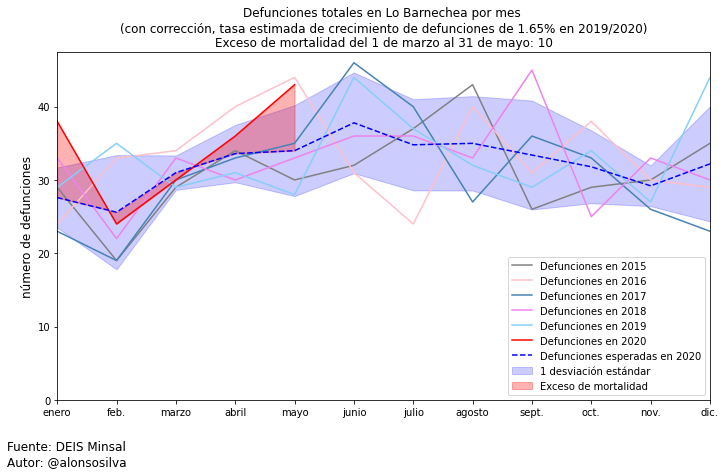

In [ ]:
plot_excess_mortality(comuna_RM, mgr_mean)

In [ ]:
print("Entre el 1 de marzo y el 31 de mayo:")
print(f"Exceso de mortalidad estimado entre {excess_mortality_march_to_may(comuna_RM, mgr_mean+mgr_std):.0f} y {excess_mortality_march_to_may(comuna_RM, mgr_mean-mgr_std):.0f}")
print(f"Exceso de mortalidad estimado más probable: {excess_mortality_march_to_may(comuna_RM, mgr_mean):.0f}")

Entre el 1 de marzo y el 31 de mayo:
Exceso de mortalidad estimado entre 8 y 12
Exceso de mortalidad estimado más probable: 10
